In [1]:
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)

In [7]:
num_words = len(words)
num_tags = len(tags)
max_len = 100
model = bigru_model(num_words, num_tags, max_len)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1344500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         44544     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 7)           903       
 ibuted)                                                         
                                                             

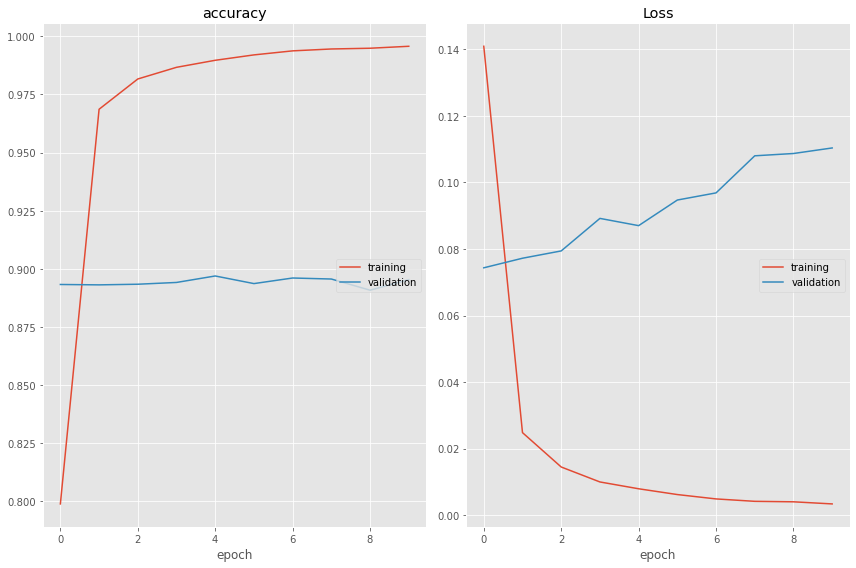

accuracy
	training         	 (min:    0.799, max:    0.996, cur:    0.996)
	validation       	 (min:    0.891, max:    0.897, cur:    0.895)
Loss
	training         	 (min:    0.003, max:    0.141, cur:    0.003)
	validation       	 (min:    0.074, max:    0.110, cur:    0.110)

Epoch 10: val_loss did not improve from 0.07434
56/56 [==============================] - 1s 14ms/step - loss: 0.1054 - accuracy: 0.8968
[0.10536827892065048, 0.8967534899711609]


In [8]:
root_path = 'model/'
model_name = 'gru_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [9]:
from keras.models import load_model

mdl = load_model('model/gru_model.h5')

In [18]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    p = mdl.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

Cara                          ID        	ID
menghilangkan                 ID        	ID
ovt                           EN        	EN
gimana                        ID        	ID
:D                            O         	O
,                             O         	O
walau                         ID        	ID
udh                           ID        	ID
mule                          ID        	ID
teneg                         ID        	ID
tapi                          ID        	ID
ga                            ID        	ID
teneg                         ID        	ID
lagi                          ID        	ID
jadinya                       ID        	ID
(                             O         	O
harusnya                      ID        	ID
ke                            ID        	ID
priv                          EN        	ID
tapi                          ID        	ID
males                         ID        	ID
switch                        EN        	EN
acc                           EN   

In [19]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.8910    0.9630    0.9256     22310
          JV     0.8856    0.7724    0.8252      4913
          EN     0.8993    0.8262    0.8612      5018
   MIX-ID-EN     0.9477    0.7821    0.8570       973
   MIX-ID-JV     0.9803    0.7107    0.8240       280
   MIX-JV-EN     0.9289    0.7545    0.8327       277
           O     0.8926    0.8517    0.8717     10153

    accuracy                         0.8934     43924
   macro avg     0.9179    0.8087    0.8568     43924
weighted avg     0.8938    0.8934    0.8918     43924



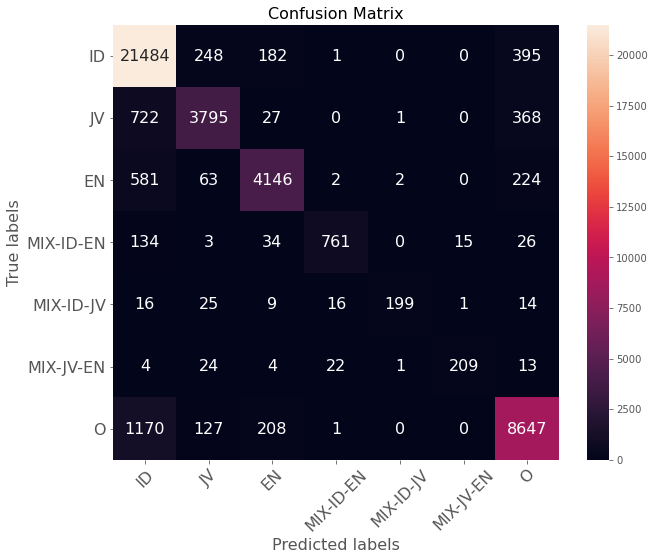

              precision    recall  f1-score   support

          ID     0.8910    0.9630    0.9256     22310
          JV     0.8856    0.7724    0.8252      4913
          EN     0.8993    0.8262    0.8612      5018
   MIX-ID-EN     0.9477    0.7821    0.8570       973
   MIX-ID-JV     0.9803    0.7107    0.8240       280
   MIX-JV-EN     0.9289    0.7545    0.8327       277
           O     0.8926    0.8517    0.8717     10153

    accuracy                         0.8934     43924
   macro avg     0.9179    0.8087    0.8568     43924
weighted avg     0.8938    0.8934    0.8918     43924



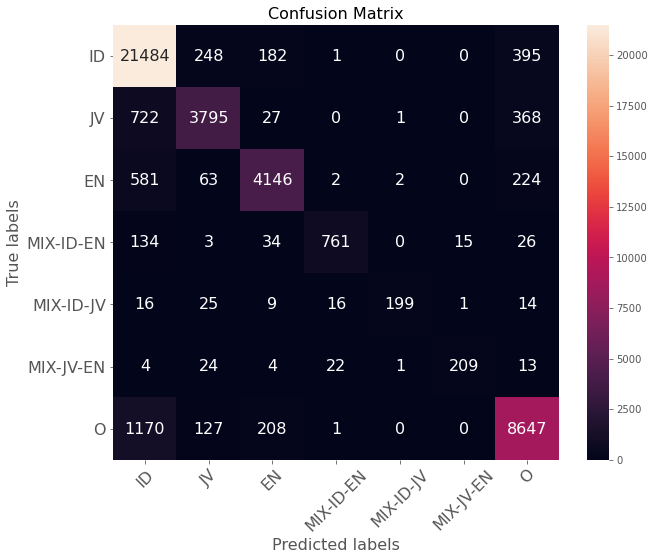

In [20]:
performance_report(true_flat, pred_flat)

In [21]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

In [22]:
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)

In [23]:
true_pred_file = 'tagging_result/compare_results_gru.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")

    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()

In [24]:
i = np.random.randint(0, X_test.shape[0]) #659
p = mdl.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w-1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
Halo                          ID        	ID
ada                           ID        	ID
yang                          ID        	ID
pernah                        ID        	ID
transaksi                     ID        	ID
pake                          ID        	ID
DANA                          O         	ID
dan                           ID        	ID
salah                         ID        	ID
nomor                         ID        	ID
gak                           ID        	ID
ya                            ID        	ID
??                            O         	O
aku                           ID        	ID
abis                          ID        	ID
transaksi                     ID        	ID
tapi                          ID        	ID
salah                         ID        	ID
nomor                         ID        	ID
,                             O         	O
dan          

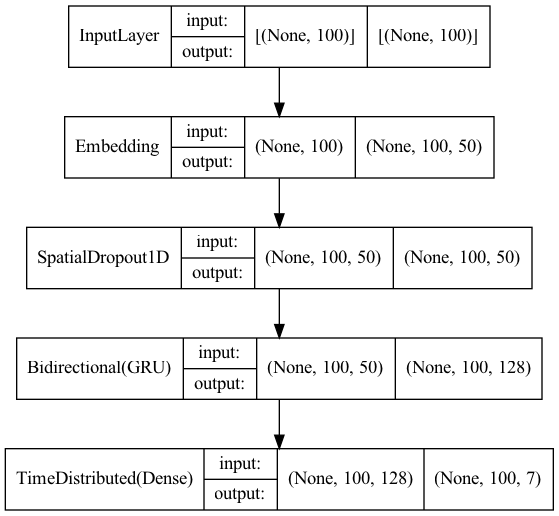

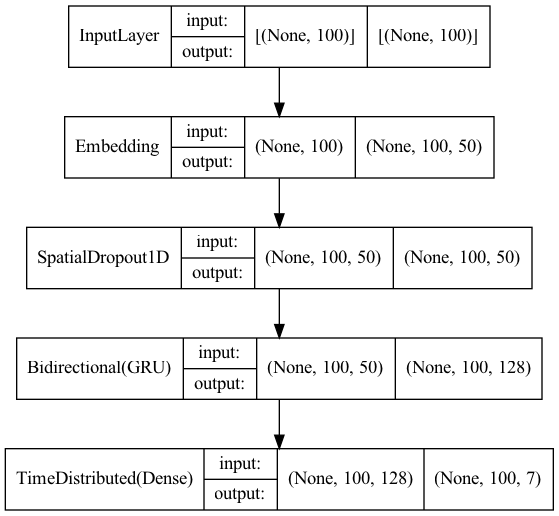

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(mdl, to_file='model_plot/tr_bigru.png', show_shapes=True, show_layer_names=False)